In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator


C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\tbasi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\tbasi\AppData\Local\Temp\ipykernel_2500\631992182.py:17: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


## Depolarizing

The depolarizing dynamical map is defined by:

$$ \epsilon(\rho) = (1-3p/4) \rho + (p/4) \sigma_1 \rho \sigma_1 + (p/4) \sigma_2 \rho \sigma_2 + (p/4) \sigma_3 \rho \sigma_3 $$

As seen in the text, to implement this types of maps, we need to create the state $|\beta(p)\rangle = \sqrt{1-3p/4} |0\rangle + \sqrt{p/4} |1\rangle + \sqrt{p/4} |2 \rangle + \sqrt{p/4} |3 \rangle$ on the ancilla qubits.

This state we want to create can be rewritten as:


$ = e^{is} \left(\dfrac{1}{2}, \dfrac{-i}{2\sqrt{3}}, \dfrac{-i}{2\sqrt{3}}, \dfrac{-i}{2\sqrt{3}} \right) + e^{-is}\left(\dfrac{1}{2}, \dfrac{i}{2\sqrt{3}}, \dfrac{i}{2\sqrt{3}},\dfrac{i}{2\sqrt{3}} \right)  = |c\rangle + |a\rangle e^{is} + |b\rangle e^{-is}$,

so that $|c\rangle= 0$, $|a\rangle = \dfrac{1}{2}|0\rangle - \dfrac{i}{2\sqrt{3}} |1\rangle - \dfrac{i}{2\sqrt{3}} |2\rangle - \dfrac{i}{2\sqrt{3}} |3\rangle$ and $|b\rangle = \dfrac{1}{2} |0\rangle + \dfrac{i}{2\sqrt{3}} |1\rangle + \dfrac{i}{2\sqrt{3}} |2 \rangle  + \dfrac{i}{2\sqrt{3}} |3\rangle $,

with $\sin s = \sqrt{3p/4}$. Therefore, the matrices $A$ and $B$ described in the article can be taken to be:

$ B = \begin{pmatrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1/\sqrt{2} & -1/\sqrt{2} & 0 & 0 \\
1/\sqrt{2} & 1/\sqrt{2} & 0 & 0
\end{pmatrix}$


$ A = \begin{pmatrix}
0 & 0 & 1/\sqrt{2} & 1/\sqrt{2} \\
1/\sqrt{6} & -1/\sqrt{2} & i/\sqrt{6} & -i/\sqrt{6} \\
1/\sqrt{6} & 1/\sqrt{2} & i/\sqrt{6} & -i/\sqrt{6} \\
-\sqrt{2/3} & 0 & i/\sqrt{6} & -i/\sqrt{6} \\
\end{pmatrix}$





First, we define a function that builds the circuit as shown in figure 5 of the article for any value of $p$.

In [4]:
B = np.array([[0,0,0,1],
             [0,0,1,0],
            [1/2**0.5,-1/2**0.5,0,0],
              [1/2**0.5,1/2**0.5,0,0]])

A = np.array([[0,0,1/2**0.5,1/2**0.5],
             [1/6**0.5,-1/2**0.5,1j/6**0.5,-1j/6**0.5],
             [1/6**0.5,1/2**0.5,1j/6**0.5,-1j/6**0.5],
             [-(2/3)**0.5,0,1j/6**0.5,-1j/6**0.5]])




def circ_depo(p):
    '''Function that creates a circuit for depolarizing channel.
    Args:
        p: Value for the depolarizing.
        
    Returns:
        A circuit that applies depolarizing with value $p$ to qubit 0.
    '''
    
    s = np.arcsin(np.sqrt(3*p/4))
    
    qreg_q = QuantumRegister(3, 'q')  
    circ = QuantumCircuit(3)

    circ.unitary(qi.operators.Operator(B),[2,1],label='B')
    
    circ.crz(2*s,qreg_q[1],qreg_q[2])
    
    circ.unitary(qi.operators.Operator(A),[2,1],label='A')
    
    c2y = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='01')
    c2x = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    c2z = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    circ.append(c2x, [1, 2, 0])
    circ.append(c2y, [1, 2, 0])
    circ.append(c2z, [1, 2, 0])

    return(circ)

depo = circ_depo(0.4)
depo.draw()


┌───┐┌───┐   
q_0: ──────────────────────────┤ X ├┤ Y ├─■─
     ┌────┐              ┌────┐└─┬─┘└─┬─┘ │ 
q_1: ┤1   ├──────■───────┤1   ├──o────■───■─
     │  B │┌─────┴──────┐│  A │  │    │   │ 
q_2: ┤0   ├┤ Rz(1.1593) ├┤0   ├──■────o───■─
     └────┘└────────────┘└────┘

### Simulation of Depolarizing channel

The following function calculates the theoretical value of the choi matrix for the depolarizing channel.

In [22]:
import qiskit.quantum_info.operators.channel.transformations as qtrans
def choi_depo(p):    
    k = qiskit.quantum_info.Kraus([np.sqrt((1-3*p/4))*I,np.sqrt(p/4)*X,
                               np.sqrt(p/4)*Y,np.sqrt(p/4)*Z])
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(Choi(mat_choi))

choi_objetivo = choi_depo(0.4)

Log in to ibmq account

In [23]:

from qiskit import IBMQ
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2023-09-17 16:30:49,460: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
# We will do it for 25 values of p from 0 to 1
points = np.linspace(0,1,25)
print("Amount of channels: ", len(points))
points

Amount of channels:  25


array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])

In [25]:
#  We create the circuits for these points.
circuits= []
for p in points:
    circuits.append(circ_depo(p))


In [ ]:
# backend = Aer.get_backend('aer_simulator')
backend = provider.get_backend('ibmq_lima')

with open("Results/Dynamical/depolarizing-fidelities.csv","w") as f:
#     f.write("p,fid")
    
    for i in range(len(points)):
        print(i)
        p = points[i]
        
        circ = circuits[i]
        res = []
        
        f.write("\n" + str(p))
    #We take 20 repetitions for each value of p
        for j in range(20):
            qpt = ProcessTomography(circ,backend,measurement_indices=[0],
                            preparation_indices=[0])
            
            qpt.set_run_options(shots=20000)
            
            qpt_run = qpt.run()
            qptdata = qpt_run.block_for_results()
            
            choi_simu = qptdata.analysis_results("state").value
            choi_theo = choi_depo(p)

            dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
            
            res.append(1-0.5*dis) 

            f.write(','+ str(1-0.5*dis))

    


Text(0, 0.5, 'f')

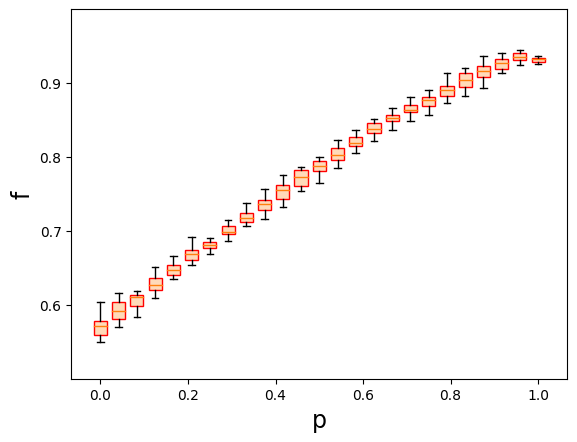

In [138]:
import pandas as pd

df = pd.read_csv("Results/Dynamical/depolarizing-fidelities.csv",header=None)
    
    
plt.boxplot(df.iloc[:,1:].T,positions= np.array(df.iloc[:,0]).T,
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="peachpuff", color="red"));
plt.ylim([0.5,1])
plt.yticks([0.6,0.7,0.8,0.9])
# plt.title("Depolarizing dynamical map fidelities")
plt.xlabel("p",fontsize=17)
plt.ylabel("f",fontsize=17)

### Parabolic

We now do the same for the parabolic map:

<br>
This map is defined by

$$ \tau_1 = p, \tau_2 = p, \tau_3 = p^2$$
Con $p \in [-1,1]$,

which means that:
$$ k_0 = 1/4(1+p)^2  \\
k_1 = 1/4(1-p^2) \\
k_2 = 1/4(1-p^2) \\
k_3 = 1/4(1-p)^2 $$,

so that the maps can be represented in the Kraus representation as:


$$ \varepsilon_p(\rho) = 1/4(1-p)^2 \rho + 1/4(1-p^2) X \rho X + 1/4(1-p^2) Y \rho Y + 1/4 (1+p)^2 Z \rho Z$$

Therefore, to implement it, we need to create the state $(1/2(1-p) , 1/2\sqrt{1-p^2}, 1/2 \sqrt{1-p^2},  1/2(1+p))$ on the ancilla qubits. ancilla. This state can be rewritten as:

$(1/2(1+p) , 1/2\sqrt{1-p^2}, 1/2 \sqrt{1-p^2},  1/2(1-p)) = (1/2,0,0,1/2) + \cos s (0,1/2,1/2,0) + \sin s (-1/2,0,0,1/2)$ 

$ = (1/2,0,0,1/2) + (i/4,1/4,1/4,-i/4) e^{is} + (-i/4,1/4,1/4,i/4) e^{-is}$ <br> <br>
    
with $s = arcsin(p)$. <br>

Therefore, it can be implemented with only one parametrized rotation with $A$ and $B$ matrices defined as:


$$ B = \begin{pmatrix} 
0 &          1 & 0           & 0 \\
1/\sqrt{2} & 0 & 0           &  -1/\sqrt{2} \\
1/2 &        0 & 1/\sqrt{2} &  1/2 \\
1/2 &        0 & -1/\sqrt{2} & 1/2 
\end{pmatrix}$$


$$ A = \begin{pmatrix} 
0             &  1/\sqrt{2}    &  -i/2     & i/2 \\
-1/\sqrt{2}   & 0             &  1/2     & 1/2 \\
1/\sqrt{2}    & 0              &  1/2     & 1/2 \\
0             & 1/\sqrt{2}    &  i/2    & -i/2
\end{pmatrix} $$ 


We will define the function that creates the circuit for any value of $p$

In [28]:
# Definimos la matriz B y A
B = np.array([[0,1,0,0],
             [1/2**0.5,0,0,-1/2**0.5],
             [1/2,0,1/2**0.5,1/2],
             [1/2,0,-1/2**0.5,1/2]])


A =np.array([[0,1/2**0.5,-1j/2,1j/2],
            [-1/2**0.5,0,1/2,1/2],
            [1/2**0.5,0,1/2,1/2],
            [0,1/2**0.5,1j/2,-1j/2]])

def circ_para(p):
    '''Function to create a circuit that implements the parabolic channel
       '''
    s = np.arcsin(p)
    
    qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
    circ = QuantumCircuit(qreg_q)
    
    circ.unitary(qi.operators.Operator(B),[2,1],label='B')
    
    circ.crz(2*s,qreg_q[1],qreg_q[2])
    
    circ.unitary(qi.operators.Operator(A),[2,1],label='A')
    
    c2y = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='01')
    c2x = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    c2z = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    circ.append(c2x, [1, 2, 0])
    circ.append(c2y, [1, 2, 0])
    circ.append(c2z, [1, 2, 0])

    return(circ)

para = circ_para(0.4)
para.draw()

┌───┐┌───┐   
q_0: ───────────────────────────┤ X ├┤ Y ├─■─
     ┌────┐               ┌────┐└─┬─┘└─┬─┘ │ 
q_1: ┤1   ├───────■───────┤1   ├──o────■───■─
     │  B │┌──────┴──────┐│  A │  │    │   │ 
q_2: ┤0   ├┤ Rz(0.82303) ├┤0   ├──■────o───■─
     └────┘└─────────────┘└────┘

In [29]:
def choi_para(p):    
    k = qiskit.quantum_info.Kraus([1/2*(1-p)*I,1/2*np.sqrt(1-p**2)*X,
                               1/2*np.sqrt(1-p**2)*Y,1/2*(1+p)*Z])
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(Choi(mat_choi))


In [30]:
# We will do it for 25 values of p from -1 to 1
points = np.linspace(-1,1,25)
print("Amount of channels: ", len(points))
points

circuits= []
for p in points:
    circuits.append(circ_para(p))


Amount of channels:  25


In [31]:

from qiskit import IBMQ
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2023-09-17 17:00:44,280: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# backend = Aer.get_backend('aer_simulator')
backend = provider.get_backend('ibmq_lima')

with open("Results/Dynamical/parabolic-fidelities.csv","w") as f:
    
    for i in range(len(points)):
        print(i)
        p = points[i]
        
        circ = circuits[i]
        res = []
        
        f.write("\n" + str(p))
    #We take 20 repetitions for each value of p
        for j in range(20):
            qpt = ProcessTomography(circ,backend,measurement_indices=[0],
                            preparation_indices=[0])
            
            qpt.set_run_options(shots=20000)
            
            qpt_run = qpt.run()
            qptdata = qpt_run.block_for_results()
            
            choi_simu = qptdata.analysis_results("state").value
            choi_theo = choi_para(p)

            dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
            
            res.append(1-0.5*dis) 

            f.write(','+ str(1-0.5*dis))

    


Text(0, 0.5, 'f')

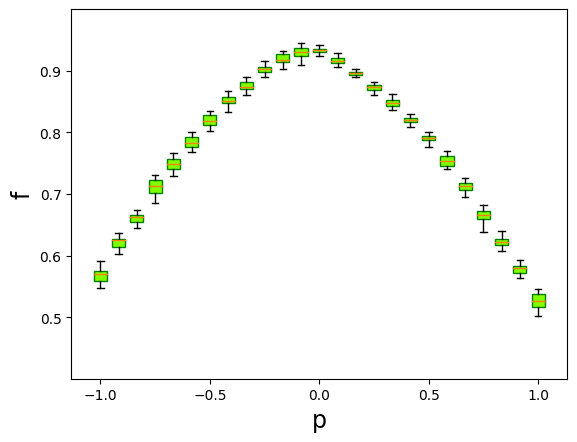

In [136]:
import pandas as pd

df = pd.read_csv("Results/Dynamical/parabolic-fidelities.csv",header=None)
    
    
plt.boxplot(df.iloc[:,1:].T,positions= np.array(df.iloc[:,0]).T,
            widths=0.06, showcaps =True,
           manage_ticks=False,
           showfliers =False,
           patch_artist=True,
            boxprops=dict(facecolor="chartreuse", color="green")
           
           );
plt.ylim([0.4,1])
plt.yticks([0.5,0.6,0.7,0.8,0.9])
# plt.title("Parabolic dynamical map fidelities")
plt.xlabel("p",fontsize=17)
plt.ylabel("f",fontsize=17)

## Bit Flip

The bit flip dynamical map is defined by:

$$ \epsilon(\rho) = (1-p) \rho + p \sigma_3 \rho \sigma_3 $$

As seen in the text, to implement this map, we need to create the state $|\beta(p)\rangle = \sqrt{1-p} |0\rangle + \sqrt{p} |1\rangle on the ancilla qubits (in this case one qubit is enough).

This state we want to create can be rewritten as:

$ |\beta(p) \rangle = e^{is} \left( \dfrac{1}{2} |0\rangle + \dfrac{-i}{2} |1\rangle \right)+ e^{-is} \left( \dfrac{1}{2} |0\rangle + \dfrac{i}{2} |1\rangle \right)
 = |c \rangle + |a\rangle e^{is} + |b\rangle e^{-is}$,

so that $|c\rangle= 0$, $|a\rangle = \dfrac{1}{2} |0\rangle + \dfrac{-i}{2} |1\rangle $ and $|b\rangle =\dfrac{1}{2} |0\rangle + \dfrac{i}{2} |1\rangle $,

with $\sin s = \sqrt{p}$. Therefore, the matrices $A$ and $B$ described in the article can be taken to be:

$ B = \begin{pmatrix}
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1/\sqrt{2} & -1/\sqrt{2} & 0 & 0 \\
1/\sqrt{2} & 1/\sqrt{2} & 0 & 0
\end{pmatrix}$


$ A = \begin{pmatrix}
0 & 0 & 1/\sqrt{2} & 1/\sqrt{2} \\
0 & 0 & i/\sqrt{2} & -i/\sqrt{2} \\
1/\sqrt{2} & 1/\sqrt{2} & 0 & 0 \\
1/\sqrt{2} & -1/\sqrt{2} & 0 & 0  \\
\end{pmatrix}$






In [2]:
B = np.array([[0,0,0,1],
             [0,0,1,0],
            [1/2**0.5,-1/2**0.5,0,0],
              [1/2**0.5,1/2**0.5,0,0]])

A = np.array([[0,0,1/2**0.5,1/2**0.5],
              [0,0,1j/2**0.5,-1j/2**0.5],
              [1/2**0.5,1/2**0.5,0,0],
              [1/2**0.5,-1/2**0.5,0,0]])




def circ_flip(p):
    '''Function that creates a circuit for depolarizing channel.
    Args:
        p: Value for the depolarizing.
        
    Returns:
        A circuit that applies depolarizing with value $p$ to qubit 0.
    '''
    
    s = np.arcsin(np.sqrt(p))
    
    qreg_q = QuantumRegister(3, 'q')  
    circ = QuantumCircuit(3)

    circ.unitary(qi.operators.Operator(B),[2,1],label='B')
    
    circ.crz(2*s,qreg_q[1],qreg_q[2])
    
    circ.unitary(qi.operators.Operator(A),[2,1],label='A')
    
    c2y = YGate.control(YGate(),num_ctrl_qubits=2,ctrl_state='01')
    c2x = XGate.control(XGate(),num_ctrl_qubits=2,ctrl_state='10')
    c2z = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='11')
    circ.append(c2x, [1, 2, 0])
    circ.append(c2y, [1, 2, 0])
    circ.append(c2z, [1, 2, 0])

    return(circ)

flip = circ_flip(0.4)
flip.draw()


┌───┐┌───┐   
q_0: ──────────────────────────┤ X ├┤ Y ├─■─
     ┌────┐              ┌────┐└─┬─┘└─┬─┘ │ 
q_1: ┤1   ├──────■───────┤1   ├──o────■───■─
     │  B │┌─────┴──────┐│  A │  │    │   │ 
q_2: ┤0   ├┤ Rz(1.3694) ├┤0   ├──■────o───■─
     └────┘└────────────┘└────┘

In [3]:
import qiskit.quantum_info.operators.channel.transformations as qtrans
def choi_flip(p):    
    k = qiskit.quantum_info.Kraus([np.sqrt(1-p)*I,np.sqrt(p)*X])
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(Choi(mat_choi))



In [4]:
from qiskit import IBMQ
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

# We will do it for 25 values of p from 0 to 1
points = np.linspace(0,1,25)
print("Amount of channels: ", len(points))
points




C:\Users\tbasi\AppData\Local\Temp\ipykernel_16228\1661332501.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
C:\Users\tbasi\AppData\Local\Temp\ipykernel_16228\1661332501.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


Amount of channels:  25


array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])

In [5]:
# We create the circuits for these points.
circuits= []
for p in points:
    circuits.append(circ_flip(p))


In [ ]:
# backend = Aer.get_backend('aer_simulator')
backend = provider.get_backend('ibmq_lima')


with open("Results/Dynamical/bit-flip-fidelities.csv","w") as f:
#     f.write("p,fid")
    
    for i in range(len(points)):
        print(i)
        p = points[i]
        
        circ = circuits[i]
        res = []
        
        f.write("\n" + str(p))
    #We take 20 repetitions for each value of p
        for j in range(20):
            qpt = ProcessTomography(circ,backend,measurement_indices=[0],
                            preparation_indices=[0])
            
            qpt.set_run_options(shots=20000)
            
            qpt_run = qpt.run()
            qptdata = qpt_run.block_for_results()
            
            choi_simu = qptdata.analysis_results("state").value
            choi_theo = choi_flip(p)

            dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
            
            res.append(1-0.5*dis) 

            f.write(','+ str(1-0.5*dis))

    


Text(0, 0.5, 'f')

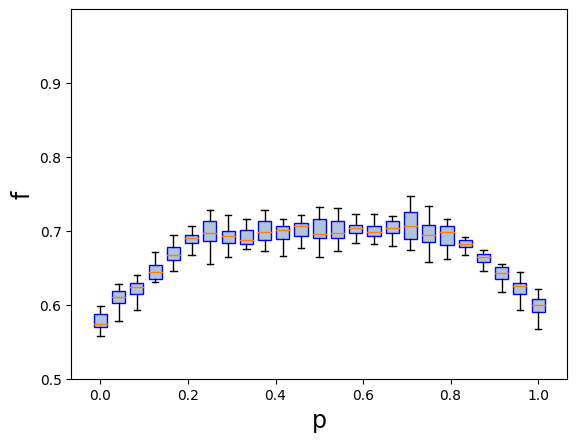

In [8]:
import pandas as pd



df = pd.read_csv("Results/Dynamical/bit-flip-fidelities.csv",header=None)


plt.boxplot(df.iloc[:,1:].T,positions= np.array(df.iloc[:,0]).T,
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="lightsteelblue", color="blue"));


plt.ylim([0.5,1])
plt.yticks([0.5,0.6,0.7,0.8,0.9])
# plt.title("Bit flip dynamical map fidelities")
plt.xlabel("p",fontsize=17)
plt.ylabel("f",fontsize=17)

Text(0, 0.5, 'f')

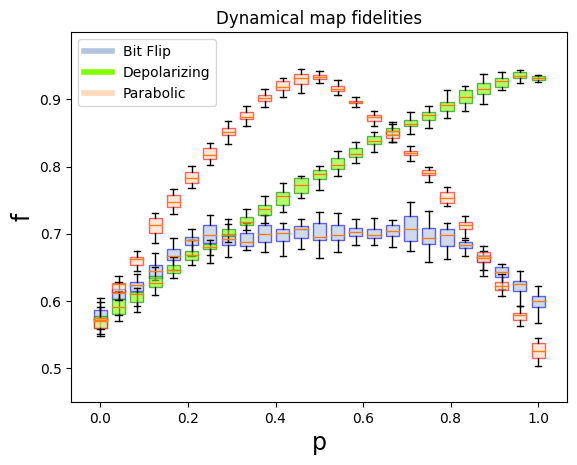

In [5]:
import pandas as pd

df1 = pd.read_csv("Results/Dynamical/bit-flip-fidelities.csv",header=None)
df2 = pd.read_csv("Results/Dynamical/depolarizing-fidelities.csv",header=None)
df3 = pd.read_csv("Results/Dynamical/parabolic-fidelities.csv",header=None)


plt.boxplot(df1.iloc[:,1:].T,positions= np.array(df1.iloc[:,0]).T,
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="lightsteelblue", color="blue",
                         alpha = 0.6));

plt.boxplot(df2.iloc[:,1:].T,positions= np.array(df2.iloc[:,0]).T,
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="chartreuse", color="green",
                          alpha=0.6));

plt.boxplot(df3.iloc[:,1:].T,positions= np.array(df2.iloc[:,0]).T,
            widths=0.03, showcaps =True,
           manage_ticks=False,
           showfliers =False,patch_artist=True,
            boxprops=dict(facecolor="peachpuff", color="red",
                         alpha = 0.6));

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="lightsteelblue", lw=4),
                Line2D([0], [0], color="chartreuse", lw=4),
                Line2D([0], [0], color="peachpuff", lw=4)]


plt.legend(custom_lines, ['Bit Flip', 'Depolarizing', 'Parabolic'])

plt.ylim([0.45,1])
plt.yticks([0.5,0.6,0.7,0.8,0.9])
plt.title("Dynamical map fidelities")
plt.xlabel("p",fontsize=17)
plt.ylabel("f",fontsize=17)